# TRABAJO Parte 2: AIA_2022-2023

# Transfer Learning con CNNs - Dataset: Flowers

La idea de este trabajo es familiarizarnos con dos situaciones muy habituales en la actividad real de un "Machine Learning Engineer":

1.   En primer lugar, con una de las técnicas más potentes asociadas con las redes neuronales: el **Transfer Learning**. Dado que las redes neuronales, para resolver un problema, capturan en su estructura de capas y pesos una representación jerárquica del problema.
Entonces..., ¿por qué no aprovechar ese conocimiento obtenido, para resolver otro problema diferente?

2.  En segundo lugar, con la **busqueda de información sobre conceptos nuevos**. En este caso, los dos primeros modelos a implementar los hemos trabajado en clase. No así el Transfer Learning, y por tanto, deberéis buscar vosotros mismos cómo hacer lo que se pide para el Modelo 3. Consultar en blogs, web y tutoriales es algo común en el día a día de alguien que quiere profundizar en el ML y, para ello, existen infinidad de fuentes. A modo de ejemplo, una fuente para profundizar en el Transfer Learning con redes convolucionales es: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

En este trabajo vamos intentar resolver un problema de clasificación sobre un dataset propuesto por Tensorflow en 2019 conocido como "flowers". Este conjunto está formado por 3670 imágenes de flores pertenecientes a 5 clases diferentes. Para ello implementaremos 3 modelos:

*   Modelo 1: implementación de una CNN básica.
*   Modelo 2: es una evolución del modelo anterior, aplicando técnicas que reduzcan el overfitting.
*   Modelo 3: rompemos la barrera de tener que seguir complicando nuestro modelo y se pide aplicar transfer learning utilizando un pre-trained model.





# a) Carga de datos

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import pathlib
import os
import glob
import shutil
tf.__version__

'2.12.0'

Descargamos el dataset que pone a nuestra disposición Tensorflow.

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 11s 0us/step


Tras completar la descarga, debemos tener la siguiente estructura de directorios:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Desgraciadamente, para este dataset, Tensorflow no nos proporciona la estructura de directorios necesaria de train y de validación. Por lo que debemos proceder del siguiente modo:

* Crear una carpeta `train` y de `val`, cada una de ellas debe contener a su vez, cinco subdirectorios: uno para cada clase de flor.
* Moveremos las imágenes de las carpetas originales a estas nuevas carpetas. De modo que el 80% de las imágenes vayan al conjunto de train y el 20% restante al de validación.
* La estructura final de directorios debe ser la siguiente:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [12.jpg, 28.jpg, 31.jpg ....]
    |______ <b>dandelion</b>: [41.jpg, 22.jpg, 35.jpg ....]
    |______ <b>roses</b>: [121.jpg, 92.jpg, 38.jpg ....]
    |______ <b>sunflowers</b>: [93.jpg, 23.jpg, 83.jpg ....]
    |______ <b>tulips</b>: [109.jpg, 267.jpg, 93.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Creamos una lista con el nombre de las 5 clases. En castellano sería: margaritas, diente de león, rosas, girasoles y tulipanes.

In [3]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Creemos la estructura de directorios necesaria:

In [4]:
SPLIT_RATIO=0.8

for cl in classes:
    # path de las imagenes de la clase cl
    img_path = os.path.join(base_dir, cl)

    # obtenemos la lista de todas las imagenes
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Imagenes".format(cl, len(images)))

    # determinamos cuantas imagenes son el 80%
    num_train = int(round(len(images)*SPLIT_RATIO))

    # separamos las imagenes en dos listas
    train, val = images[:num_train], images[num_train:]

    # creamos la carpeta de train/clase y val/clase
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))

    # movemos las imagenes
    for t in train:
        shutil.move(t, os.path.join(base_dir, 'train', cl))
    for v in val:
        shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Imagenes
daisy: 633 Imagenes
dandelion: 898 Imagenes
sunflowers: 699 Imagenes
tulips: 799 Imagenes


Preparamos variables con las rutas de los diferentes directorios:

In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

daisy_dir = os.path.join(train_dir, 'daisy')
dandelion_dir = os.path.join(train_dir, 'dandelion')
roses_dir = os.path.join(train_dir, 'roses')
sunflowers_dir = os.path.join(train_dir, 'sunflowers')
tulips_dir = os.path.join(train_dir, 'tulips')

Muestre el nombre de dos ficheros cualquiera en alguna de esas rutas:

In [6]:
os.listdir(roses_dir)[0], os.listdir(tulips_dir)[0]

('1793211631_68c31a74dc.jpg', '7448453762_aea8739f1b.jpg')

Es decir, la clase a la que pertenece cada imagen no viene dada por el nombre del fichero sino por el directorio en el que se encuentra almacenada.

Muestra el número de imágenes de train que tenemos de cada clase:

In [7]:
images_daisy = os.listdir(daisy_dir)
images_dandelion = os.listdir(dandelion_dir)
images_roses = os.listdir(roses_dir)
images_sunflowers = os.listdir(sunflowers_dir)
images_tulips = os.listdir(tulips_dir)

print("Número de imágenes de train por clase:")
print("Daisy:", len(images_daisy),"Imagenes")
print("Dandelion:", len(images_dandelion),"Imagenes")
print("Roses:", len(images_roses),"Imagenes")
print("Sunflowers:", len(images_sunflowers),"Imagenes")
print("Tulips:", len(images_tulips),"Imagenes")

Número de imágenes de train por clase:
Daisy: 506 Imagenes
Dandelion: 718 Imagenes
Roses: 513 Imagenes
Sunflowers: 559 Imagenes
Tulips: 639 Imagenes


# b) Visualización del dataset

Muestra 3 imágenes de cada una de las clases, utilizando como título de la imagen, el shape del array de numpy asociado a cada imagen. Comprueba que las imágenes tienen diferentes shapes, por lo que más adelante tendremos que unificar su tamaño.

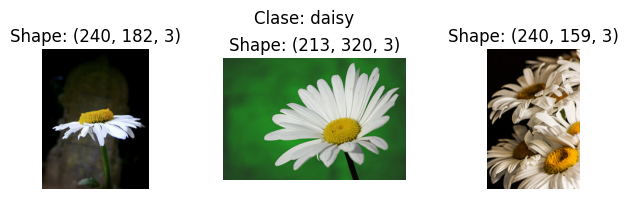

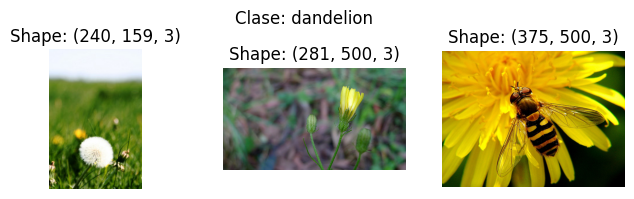

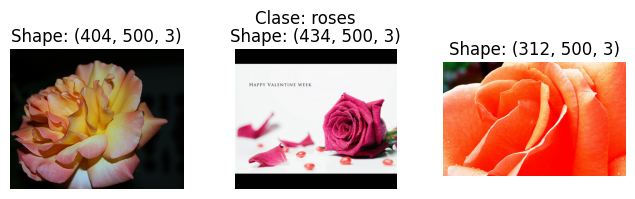

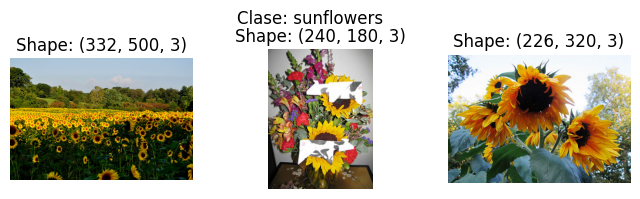

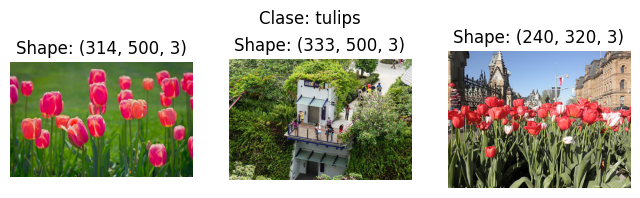

In [8]:
import matplotlib.pyplot as plt

def mostrar_imagenes(images, clase):
    plt.figure(figsize=(8, 4))
    plt.suptitle("Clase: " + clase)
    for i in range(3):
        plt.subplot(2, 3, i+1)
        img = plt.imread(os.path.join(train_dir, clase, images[i]))
        plt.imshow(img)
        plt.title("Shape: " + str(np.shape(img)))
        plt.axis("off")
    plt.show()

mostrar_imagenes(images_daisy, "daisy")
mostrar_imagenes(images_dandelion, "dandelion")
mostrar_imagenes(images_roses, "roses")
mostrar_imagenes(images_sunflowers, "sunflowers")
mostrar_imagenes(images_tulips, "tulips")

# c) Modelo 1: CNN básica (objetivo: accuracy_valid > 60%)


Implemente una red convolucional para resolver el problema de clasificación. Para ello se sugiere una CNN con 3 capas convolucionales + pooling con la siguiente estructura:

Bloque de procesamiento de imagen:
1.   32 kernels -> 64 kernels -> 96 kernels
2.   kernels de 3x3.
3.   Stride = 1 y padding = SI.
4.   Función de activación ReLU.
5.   Maxpooling de 2x2 con stride clásico de 2 pixeles.
6.   Igualamos el tamaño de todas las imágenes a 150 x 150.

Bloque de decisión:
7.   Capa densa de 512 neuronas.
8.   Capa densa de salida.

**Entrene un modelo con la estructura anterior de manera que obtenga un accuracy (sobre el conjunto de validación) > 60%.** Utilice el optimizador que considere más adecuado.

Sugerencias:
*   Recuerda que si no se realiza conversión a One-Hot de la etiqueta a predecir, debes utilizar como función de error `SparseCategoricalCrossentropy` (este es el procedimiento que hemos usado en clase).
*   Considera un learning rate en el entorno de 0.001.
*   En el caso de los generators utiliza `class_mode='sparse'`.
*   Puedes utilizar p.e. un `batch_size = 100`.




In [9]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
modelFlowers = keras.Sequential()

modelFlowers.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),
                                     strides=(1,1),padding='same',input_shape=(150,150,3),activation='relu',name='convol1'))

modelFlowers.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

modelFlowers.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),
                                     strides=(1,1),padding='same',activation='relu',name='convol2'))

modelFlowers.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

modelFlowers.add(keras.layers.Conv2D(filters=96,kernel_size=(3,3),
                                     strides=(1,1),padding='same',activation='relu',name='convol3'))

modelFlowers.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

modelFlowers.add(keras.layers.Flatten())
modelFlowers.add(keras.layers.Dense(units=512,activation='relu',name='densa1'))
modelFlowers.add(keras.layers.Dense(units=5,activation='softmax',name='densa2'))


In [ ]:
#optim = keras.optimizers.Adam(learning_rate=0.001)
optim = keras.optimizers.RMSprop(learning_rate=0.001)
#optim = keras.optimizers.SGD(learning_rate=0.001)
#optim = keras.optimizers.Adagrad(learning_rate=0.001)

modelFlowers.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optim, metrics=['acc'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=100,class_mode='sparse')
val_generator = val_datagen.flow_from_directory(val_dir,target_size=(150,150),batch_size=100,class_mode='sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [ ]:
es_callback = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
train_gen_imagenes = 2935
val_gen_imagenes = 735
batch_size=100

In [ ]:
history = modelFlowers.fit(
      train_generator,
      steps_per_epoch=train_gen_imagenes // batch_size,  # 2935 images // batch_size = steps,
      epochs=20,
      validation_data=val_generator,
      validation_steps=val_gen_imagenes // batch_size,  # 735 images // batch_size = steps,
      callbacks=[es_callback],
      verbose=2)

Epoch 1/20
29/29 - 28s - loss: 1.6670 - acc: 0.2899 - val_loss: 1.4775 - val_acc: 0.3643 - 28s/epoch - 963ms/step
Epoch 2/20
29/29 - 13s - loss: 1.3321 - acc: 0.4325 - val_loss: 1.2726 - val_acc: 0.4600 - 13s/epoch - 446ms/step
Epoch 3/20
29/29 - 13s - loss: 1.1714 - acc: 0.5153 - val_loss: 1.0742 - val_acc: 0.5529 - 13s/epoch - 447ms/step
Epoch 4/20
29/29 - 13s - loss: 1.0932 - acc: 0.5665 - val_loss: 1.0476 - val_acc: 0.5471 - 13s/epoch - 455ms/step
Epoch 5/20
29/29 - 13s - loss: 0.9834 - acc: 0.6148 - val_loss: 1.1343 - val_acc: 0.5386 - 13s/epoch - 448ms/step
Epoch 6/20
29/29 - 13s - loss: 0.9162 - acc: 0.6332 - val_loss: 0.9035 - val_acc: 0.6343 - 13s/epoch - 447ms/step
Epoch 7/20
29/29 - 14s - loss: 0.8236 - acc: 0.6825 - val_loss: 1.0715 - val_acc: 0.6171 - 14s/epoch - 482ms/step
Epoch 8/20
29/29 - 13s - loss: 0.7443 - acc: 0.7122 - val_loss: 0.8896 - val_acc: 0.6500 - 13s/epoch - 446ms/step
Epoch 9/20
29/29 - 13s - loss: 0.6624 - acc: 0.7538 - val_loss: 0.9124 - val_acc: 0.6471

Indica cual es el shape de la imagen antes y después de cada capa de la red. **Explica cómo has obtenido dichos valores**. Compara el resultado con un summary() del modelo

|Capa| Shape a la salida| #parámetros |
|:-|:-:|:-:|
|Conv_1|150-150-32| 896
|Pool_1|75-75-32| 0
|Conv_2|75-75-64| 18496
|Pool_2|37-37-64| 0
|Conv_3|37-37-96| 55392
|Pool_3|18-18-96| 0
|flatten|131424| 0
|densa_1|512| 15925760
|densa_2|5| 2565





**Así hemos obtenido estos valores:**


> Al principio las imágenes serán de (150,150,3) como está indicado en el input_shape de la primera capa convolucional. Será así dado que hemos reducido todas las imágenes a ese tamaño para que compartan dimensiones, y las imágenes tendrán 3 canales debido a que están en formato RGB.



> Trás pasar por la primera capa convolucional las dimensiones serán (150,150,32). 150,150 dado que tenemos un padding activo y stride (1,1) por lo que quedará
con las mismas dimensiones y 32 por que hemos usado 32 filtros.



> En las capas de pooling como estamos usando stride clásico y pool_size de (2,2) se reducirán las dimensiones a la mitad del valor que tenían.





> En la segunda y la tercera capa convolucional pasará igual dado que no se reducirán las dimensiones por el padding y el stride pero se cambiará el número de canales en función
del número de filtros que hay en esa capa.







In [ ]:
modelFlowers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convol1 (Conv2D)            (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 convol2 (Conv2D)            (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 convol3 (Conv2D)            (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

Muestra la evolución de la función de error (train y valid) durante el entrenamiento.__Explica qué problema presenta el modelo que hemos entrenado.__

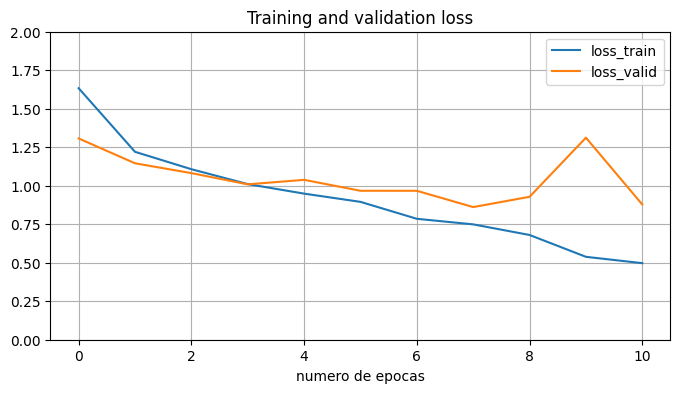

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame({'loss_train': history.history['loss'],
              'loss_valid': history.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

**Este es el problema del modelo entrenado:**

> El problema que podemos ver es que hay overfitting dado que la función de perdida de entrenamiento se va reduciendo pero la de validación deja de disminuir y se mantiene igual o
aumenta ligeramente



# d) Modelo 2: reducción del overfitting (objetivo: accuracy_valid > 70%)

Introduzca en el modelo anterior las dos técnicas más habituales de reducción del overfitting:

    * drop-out
    * data augmentation

El objetivo es alcanzar un **objetivo es conseguir un accuracy sobre el conjunto de validacion > 70%.**

**Explica en qué consisten y qué utilidad tienen para nuestro problema**

**Vamos explicar en que consisten estas técnicas:**

> La técnica de **Drop-out** es utilizada para reducir el sobreajuste en redes neuronales. Durante el entrenamiento, se apaga aleatoriamente un conjunto de neuronas
en una capa con una probabilidad determinada. Haciendo esto se evita que las neuronas dependan demasiado unas de otras y se promueve una mejor generalización del modelo.



> La técnica de **Data Augmentation** es una técnica utilizada para aumentar el tamaño y la variedad del conjunto de datos de entrenamiento al aplicar transformaciones
aleatorias a las imágenes existentes. Estan pueden ser giros, zoom, cambio de escala, recorte... Esto ayuda a mejorar el rendimiento y la capacidad de generalización del modelo
al exponerlo a diferentes variaciones de los datos de entrenamiento.



Por lo tanto nos servirán para reducir el overfitting.




__Explica qué tipos de augmentation vas a considerar y qué utilidad tienen en nuestro problema de clasificacion__:



**Tipos de data augmentation usados:**



*   **Rescale**: Este parámetro escala los valores de los píxeles de las imágenes en el rango de 0 a 1. Dividiendo cada valor por 255, se normaliza la intensidad de los píxeles.
*   **Rotation Range**: Permite rotar las imágenes en un rango determinado de grados.
*   **Width Shift Range y Height Shift Range**: Estos parámetros permiten trasladar las imágenes horizontalmente y verticalmente dentro de un rango determinado.
*    **Shear Range**: Este parámetro especifica el rango de deformación por desplazamiento de pixeles (cizallamiento) que se aplicará a las imágenes.
*   **Zoom Range**: Este parámetro permite aplicar un zoom aleatorio a las imágenes dentro de un rango determinado.
*   **Horizontal Flip y Vertical Flip**: Estos parámetros permiten voltear horizontalmente y verticalmente las imágenes de forma aleatoria.
*   **Brightness Range**: Este parámetro permite ajustar aleatoriamente el brillo de las imágenes dentro de un rango determinado.








In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [11]:
modelFlowers2 = keras.Sequential()

modelFlowers2.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),
                                     strides=(1,1),padding='same',input_shape=(150,150,3),activation='relu',name='convol1'))

modelFlowers2.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

modelFlowers2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),
                                     strides=(1,1),padding='same',activation='relu',name='convol2'))

modelFlowers2.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

modelFlowers2.add(keras.layers.Conv2D(filters=96,kernel_size=(3,3),
                                     strides=(1,1),padding='same',activation='relu',name='convol3'))

modelFlowers2.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))

modelFlowers2.add(keras.layers.Flatten())
modelFlowers2.add(keras.layers.Dense(units=512,activation='relu',name='densa1'))
modelFlowers2.add(keras.layers.Dropout(0.2))
modelFlowers2.add(keras.layers.Dense(units=5,activation='softmax',name='densa2'))

In [12]:
optim = keras.optimizers.Adam(learning_rate=0.001)
#optim = keras.optimizers.RMSprop(learning_rate=0.001)
#optim = keras.optimizers.SGD(learning_rate=0.001)
#optim = keras.optimizers.Adagrad(learning_rate=0.001)

modelFlowers2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optim, metrics=['acc'])

In [14]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2])

val_datagen2 = ImageDataGenerator(rescale=1./255)

In [15]:
es_callback = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
train_gen_imagenes = 2935
val_gen_imagenes = 735
batch_size=100

In [16]:
train_generator2 = train_datagen2.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='sparse')

val_generator2 = val_datagen2.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [17]:
history2 = modelFlowers2.fit(
      train_generator2,
      steps_per_epoch=train_gen_imagenes // batch_size,  # 2935 images // batch_size = steps,
      epochs=20,
      validation_data=val_generator2,
      validation_steps=val_gen_imagenes // batch_size,  # 735 images // batch_size = steps,
      callbacks=[es_callback],
      verbose=2)

Epoch 1/20
29/29 - 42s - loss: 1.7430 - acc: 0.3157 - val_loss: 1.3192 - val_acc: 0.4000 - 42s/epoch - 1s/step
Epoch 2/20
29/29 - 32s - loss: 1.2025 - acc: 0.4734 - val_loss: 1.1402 - val_acc: 0.5300 - 32s/epoch - 1s/step
Epoch 3/20
29/29 - 33s - loss: 1.1087 - acc: 0.5601 - val_loss: 1.0664 - val_acc: 0.5914 - 33s/epoch - 1s/step
Epoch 4/20
29/29 - 29s - loss: 1.0593 - acc: 0.5848 - val_loss: 1.0393 - val_acc: 0.5914 - 29s/epoch - 990ms/step
Epoch 5/20
29/29 - 31s - loss: 0.9807 - acc: 0.6131 - val_loss: 0.9897 - val_acc: 0.6143 - 31s/epoch - 1s/step
Epoch 6/20
29/29 - 32s - loss: 1.0103 - acc: 0.6021 - val_loss: 1.0448 - val_acc: 0.6086 - 32s/epoch - 1s/step
Epoch 7/20
29/29 - 31s - loss: 0.9511 - acc: 0.6226 - val_loss: 0.9886 - val_acc: 0.6200 - 31s/epoch - 1s/step
Epoch 8/20
29/29 - 32s - loss: 0.9258 - acc: 0.6462 - val_loss: 0.9424 - val_acc: 0.6171 - 32s/epoch - 1s/step
Epoch 9/20
29/29 - 29s - loss: 0.8756 - acc: 0.6571 - val_loss: 0.8782 - val_acc: 0.6614 - 29s/epoch - 1s/ste

Muestra la evolucion de la funcion de error durante el entrenamiento. __Explica qué diferencias de comportamiento hay entre las gráficas del modelo a) y las del modelo b)__

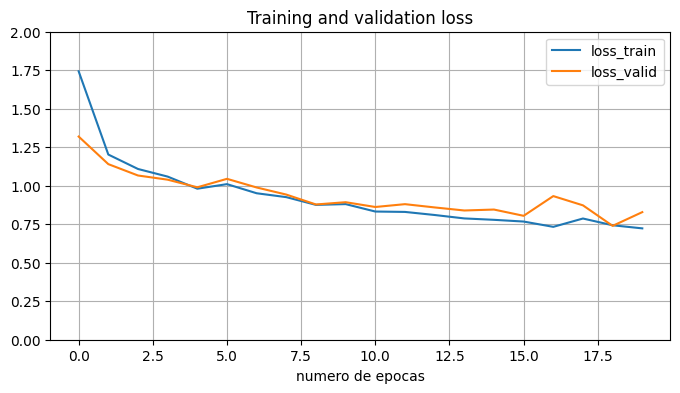

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame({'loss_train': history2.history['loss'],
              'loss_valid': history2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

**La diferencia entre ambas gráficas:**



> La diferencia reside en que ahora se producirá el overfitting en una epoch mucho más avanzada.



# c) Modelo 3: Transfer Learning (objetivo: accuracy_valid > 88%)

En nuestro problema de clasificación de flores, el utilizar CNNs diseñadas y entrenadas por nosotros mismos, aparece una barrera en las proximidades del 75-80% de precisión del modelo (siempre sobre validación).

Para superar este escollo, el siguiente paso natural es la utilización de modelos preentrenados. Existe una gran variedad de ellos basados en redes CNNs clásicas, donde la principal diferencia es que acumulan más capas que nuestros modelos 1 y 2. Adicionalmente, en estos modelos se han ido incorporando diferentes propuestas para mejorar la arquitectura de la CNN.

En general, utilizando estos modelos convolucionales preentrenados podemos alcanzar accuracies próximos al 90%. Normalmente, estos modelos han sido previamente entrenados sobre datasets de gran tamaño y con gran número de categorías. P.e. en subconjuntos de Imagenet (14 millones de imagenes de 22K categorías).

Dado que estos modelos se entrenaron para resolver un problema "relativamente" parecido a nuestro problema de clasificación, parece razonable pensar que podemos aprovechar ese conocimiento capturado en la red para resolver nuestro problema de clasificación de flores.

Se pide que implemente y entrene un modelo utilizando una de estas redes pre-entrenadas (__con el objetivo de alcanzar un accuracy (sobre el conjunto de validación > 88%__). Los pasos que debe seguir son:

1.   Importa el modelo desde Tensorflow.
2.   Dado que este modelo ha sido entrenado para clasificar entre 1.000 categorías, las capas densas finales del modelo no son útiles para nuestro problema de clasificación de 5 categorías (es lo que suele llamarse include_top = SI/NO). De manera que eliminamos lo que a veces se suele llamar el "top model". De este modo sólo nos quedamos con la parte que hace la funcionalidad de "procesamiento" de la imagen.
3.   Añadimos una capa de flatten y tres nuevas capas densas especificas para nuestro problema con dimensiones 4096, 1072 y la que necesite la capa de salida (con sus correspondientes drop-out).
4.   Después haremos el denominado `Fine-Tuning` del modelo. Para ello le indicaremos a Tensorflow que únicamente debe entrenar:
   * Las dos últimas capas convolucionales de la red preentrenada
   * Las tres capas densas que hemos incluido nuevas.

  De esta forma, quedan congeladas (no se entrenan los pesos) todas las capas convolucionales de la red preentrenada, excepto las dos últimas. Para estados dos últimas capas convolucionales, usando como punto de partida los del pre-trained model obtendremos un ajuste fino de sus pesos. Por supuesto, tensorflow entrenará no solo estas dos ultimas capas convolucionales, sino también las tres capas densas que hemos añadido.

5. Dado que estamos reutilizando un modelo que no "es nuestro", deberemos ceñirnos al tamaño de imagen que permite la red a la entrada.

Para elegir el modelo preentrenado que debe utilizar cada grupo, proceda del siguiente modo:
* Paso 1: sume los DNIs de los componentes del grupo (si el grupo tiene un sólo miembro, vaya directamente al paso 2). res = dni_1 + dn_2
* Paso 2: Aplique la siguiente operación al resultado anterior: res mod 6.
* Paso 3: Tome el modelo cuyo número asociado coincide con el resultado de la operación anterior.
* Paso 4: El porcentaje que aparece entre paréntesis junto al nombre del modelo es el accuracy (en validación) que deberías poder alcanzar sin dificultad utilizando el modelo. En todos los casos considera un input_shape = (224, 224, 3).

  0. Resnet50 (>90%)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

  1. Resnet101 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101

  2. VGG16 (>90%) input_shape = (224, 224, 3)
  https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

  3. VGG19 (>90%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

  4. Xception (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

  5. Inceptionv3 (>88%) input_shape = (224, 224, 3) https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3

P.e. si los DNIs de los alumnos son: 12345678 y 23456781. La suma es 35802467. De donde 35802467 mod 6 = 5. Por tanto, tomaríamos el modelo Inceptionv3.

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
suma_DNI = (xxxxxxxxxx + xxxxxxxxxx) % 6
suma_DNI

2

In [29]:
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

base_model.trainable = False

x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1072, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output)


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])


In [30]:
train_datagen3 = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.4],
    preprocessing_function=keras.applications.vgg16.preprocess_input)

valid_datagen3 = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)

In [31]:
train_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=120,
    class_mode='sparse'
)

val_generator3 = valid_datagen3.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=120,
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [32]:
es_callback = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
train_gen_imagenes = 2935
val_gen_imagenes = 735
batch_size=120

In [33]:
history3 = model.fit(
      train_generator3,
      steps_per_epoch=train_gen_imagenes // batch_size,  # 2935 images // batch_size = steps,
      epochs=20,
      validation_data=val_generator3,
      validation_steps=val_gen_imagenes // batch_size,  # 735 images // batch_size = steps,
      callbacks=[es_callback],
      verbose=2)

Epoch 1/20
24/24 - 60s - loss: 45.9001 - acc: 0.5115 - val_loss: 2.4495 - val_acc: 0.7194 - 60s/epoch - 3s/step
Epoch 2/20
24/24 - 63s - loss: 3.0699 - acc: 0.6792 - val_loss: 0.5775 - val_acc: 0.8153 - 63s/epoch - 3s/step
Epoch 3/20
24/24 - 56s - loss: 1.3183 - acc: 0.7183 - val_loss: 0.5110 - val_acc: 0.8403 - 56s/epoch - 2s/step
Epoch 4/20
24/24 - 55s - loss: 0.9970 - acc: 0.7240 - val_loss: 0.5398 - val_acc: 0.8250 - 55s/epoch - 2s/step
Epoch 5/20
24/24 - 56s - loss: 0.8622 - acc: 0.7332 - val_loss: 0.4548 - val_acc: 0.8472 - 56s/epoch - 2s/step
Epoch 6/20
24/24 - 61s - loss: 0.7644 - acc: 0.7552 - val_loss: 0.4637 - val_acc: 0.8458 - 61s/epoch - 3s/step
Epoch 7/20
24/24 - 61s - loss: 0.7399 - acc: 0.7570 - val_loss: 0.4472 - val_acc: 0.8389 - 61s/epoch - 3s/step
Epoch 8/20
24/24 - 61s - loss: 0.6765 - acc: 0.7716 - val_loss: 0.4048 - val_acc: 0.8458 - 61s/epoch - 3s/step
Epoch 9/20
24/24 - 56s - loss: 0.6427 - acc: 0.7865 - val_loss: 0.4181 - val_acc: 0.8708 - 56s/epoch - 2s/step




6.   Una vez definido el modelo tenemos que crear los data_generators asociados. Para ello:
> * Utiliza Data augmentation.
> * Las imágenes tienen que ser preprocesadas igual que cuando se entrenó el modelo VGG original. Para ello se utiliza el parámetro `preprocessing_function=preprocess_input` (preprocess_input importado desde `keras.applications.vgg16` en ambos generators (train y valid). Por tanto, no hay que indicarle `rescale`. En caso de ser necesario, se encargará `preprocess_input`.
> * Recuerda que el tamaño de imagen debe ser: 224x224.




In [25]:
#Aplicamos fine-tuning

for layer in base_model.layers[-2:]:
    layer.trainable = True


model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])


7.   A la hora de entrenar un modelo pretrained es típico bajar el learning rate respecto al que utilizaríamos para un modelo nuestro desde cero.

In [26]:
history4 = model.fit(
      train_generator3,
      steps_per_epoch=train_gen_imagenes // batch_size,  # 2935 images // batch_size = steps,
      epochs=20,
      validation_data=val_generator3,
      validation_steps=val_gen_imagenes // batch_size,  # 735 images // batch_size = steps,
      callbacks=[es_callback],
      verbose=2)

Epoch 1/20
24/24 - 60s - loss: 21.1329 - acc: 0.5020 - val_loss: 1.0941 - val_acc: 0.7486 - 60s/epoch - 3s/step
Epoch 2/20
24/24 - 62s - loss: 1.6947 - acc: 0.6700 - val_loss: 0.7497 - val_acc: 0.7958 - 62s/epoch - 3s/step
Epoch 3/20
24/24 - 61s - loss: 1.1101 - acc: 0.7190 - val_loss: 0.5746 - val_acc: 0.8250 - 61s/epoch - 3s/step
Epoch 4/20
24/24 - 56s - loss: 0.9692 - acc: 0.7535 - val_loss: 0.5066 - val_acc: 0.8569 - 56s/epoch - 2s/step
Epoch 5/20
24/24 - 63s - loss: 0.8208 - acc: 0.7702 - val_loss: 0.4581 - val_acc: 0.8722 - 63s/epoch - 3s/step
Epoch 6/20
24/24 - 63s - loss: 0.6719 - acc: 0.8096 - val_loss: 0.4326 - val_acc: 0.8764 - 63s/epoch - 3s/step
Epoch 7/20
24/24 - 63s - loss: 0.6346 - acc: 0.8107 - val_loss: 0.4093 - val_acc: 0.8694 - 63s/epoch - 3s/step
Epoch 8/20
24/24 - 64s - loss: 0.5881 - acc: 0.8291 - val_loss: 0.3871 - val_acc: 0.8861 - 64s/epoch - 3s/step
Epoch 9/20
24/24 - 58s - loss: 0.5015 - acc: 0.8423 - val_loss: 0.3644 - val_acc: 0.8889 - 58s/epoch - 2s/step


Investiga cómo es la estructura del modelo preentrenado que has utilizado. Descríbelo

**Vamos a comentar la estructura del VGG16:**



> Este modelo es conocido por su profundidad, ya que consta de 16 capas.

> Capa de entrada: La imagen de entrada se pasa a través de esta capa, que generalmente es de tamaño 224x224 píxeles.

> Capas convolucionales: VGG16 tiene un total de 13 capas convolucionales, cada una seguida de una función de activación ReLU. Cada capa convolucional utiliza filtros de tamaño 3x3 con un paso de 1 píxel y un relleno (padding) de 1 píxel.

> Capas de pooling: Después de cada par de capas convolucionales, se aplica una capa de agrupación MaxPooling de 2x2 y un stride de 2 píxeles. Esto reduce la dimensionalidad y ayuda a capturar la información más relevante.

> Capas densas: Después de las capas convolucionales y de pooling, las características se aplanan y se pasan a través de tres capas totalmente conectadas con 4096 unidades cada una. Cada capa está seguida de una función de activación ReLU. Estas capas finales de la red son responsables de la clasificación y toman las características extraídas para producir la salida final.

> Capa de salida: La última capa totalmente conectada tiene 1000 unidades, correspondientes a las clases de salida posibles en el conjunto de datos ImageNet, en el cual VGG16 fue entrenado originalmente. Se utiliza una función de activación softmax para obtener la distribución de probabilidad de las clases. Nosotros en nuestro caso desactivaremos esta capa y utilizaremos una capa de salida acorde a nuestro problema (con 5 neuronas).

En resumen, VGG16 es un modelo CNN con 16 capas, que combina capas convolucionales y de pooling para extraer características de una imagen y capas totalmente conectadas para la clasificación final. Es ampliamente utilizado como base para tareas de clasificación de imágenes y extracción de características.
